# Load DeepLSD and predict lines

In [20]:

import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines
import os
import numpy as np
import cv2
import torch
import h5py
from deeplsd.models.deeplsd_inference import DeepLSD

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])

with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
# Initialize DeepLSD model

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Find which lines are structural using Sobel gradient map for depth and normals

14.836272141489573
-2.706168622523819e-16
-1.104496294380946


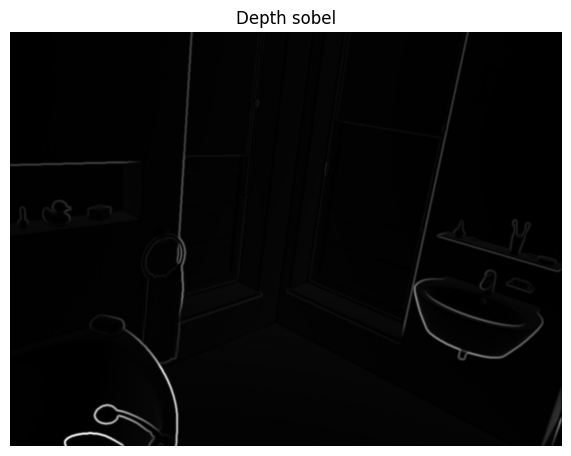

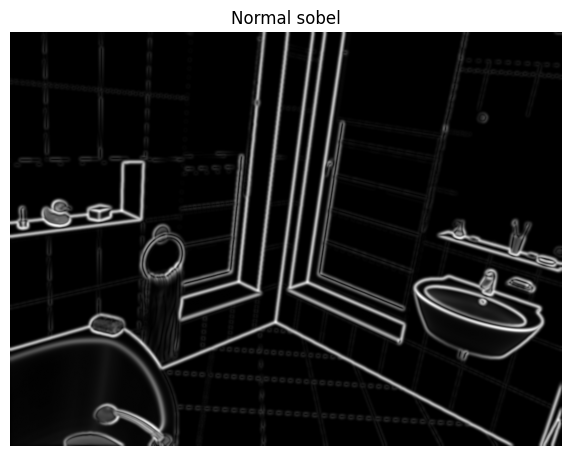

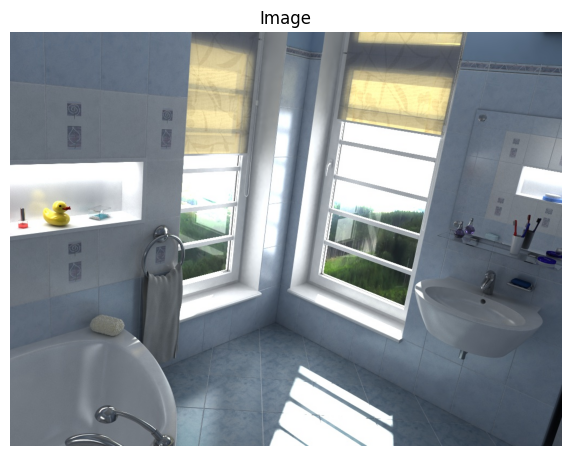

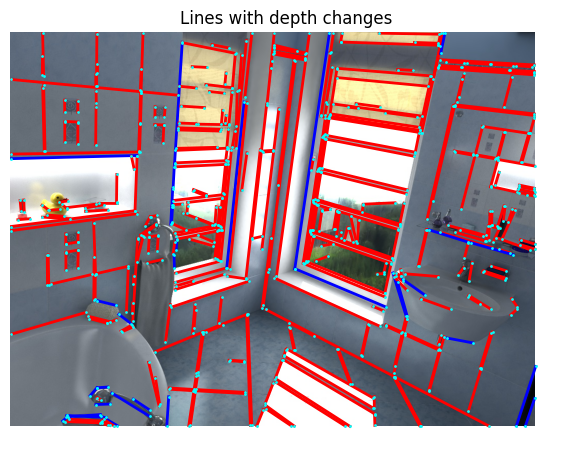

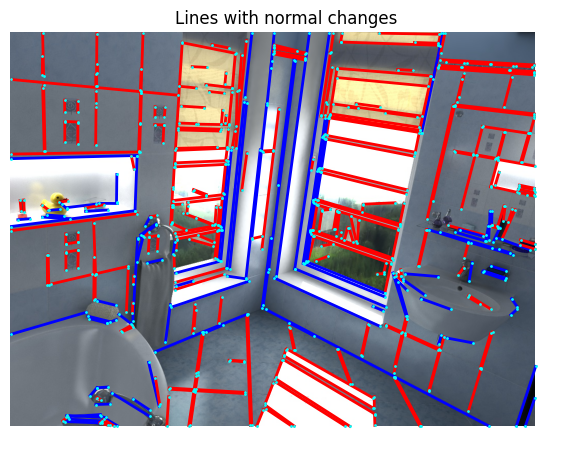

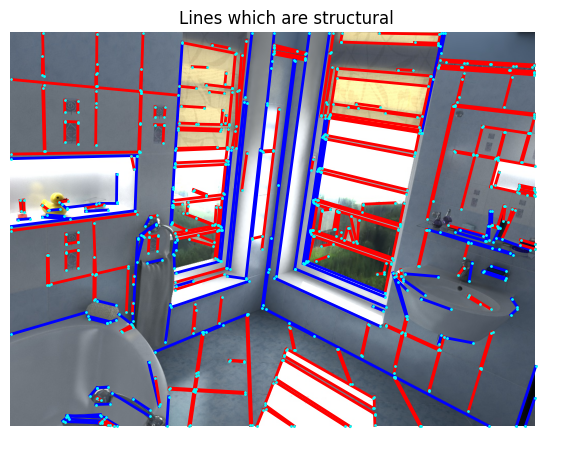

In [21]:

# Function to compute Sobel map
def compute_variation(mapping, k):
    grad_x = cv2.Sobel(mapping, cv2.CV_64F, 1, 0, ksize=k)
    grad_y = cv2.Sobel(mapping, cv2.CV_64F, 0, 1, ksize=k)
    variation = np.sqrt(grad_x**2 + grad_y**2)

    mean = np.mean(variation)
    std_dev = np.std(variation)
    normalized_matrix = (variation - mean) / std_dev

    return normalized_matrix

#Computes maps, we chose these kernel parameters for the moment
sobel_depth_map = compute_variation(depth_map,11)
sobel_normal_map = compute_variation(normal_map, 27)

#Aggregate normal dimensions in to one dimension using max (find maximum change)
sobel_normal_map = np.sum((sobel_normal_map), axis=2, keepdims=True)


print(np.max(sobel_normal_map))
print(np.mean(sobel_normal_map))
print(np.min(sobel_normal_map))

plot_images([sobel_depth_map], ["Depth sobel"], cmaps='gray')
plot_images([(sobel_normal_map)], ['Normal sobel'], cmaps='gray')

#Find values on sobel map which are on the line
def sobel_line(sobel_depth, sobel_normal, line):
    x1, y1, x2, y2 = int(line[0,0]), int(line[0,1]), int(line[1,0]), int(line[1,1])
    line_values_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, 1) * sobel_depth
    line_values_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, 1) * sobel_normal

    return line_values_depth, line_values_normal

#Find which lines have strong changes in depth or normal
isdepth =[]
isnormal = []
isstruct = []
for l in (pred_lines):
    sobel_depths, sobel_normals = sobel_line(sobel_depth_map, sobel_normal_map, l)
    depthbool = np.mean(sobel_depths) > 0.0001
    #depthbool = np.max(sobel_depths) > 0.00000005 #or np.mean(sobel_depths) < 0.01
    normalbool = np.mean((sobel_normals)) > 0.0001
    isdepth.append(depthbool)
    isnormal.append(normalbool)
    isstruct.append(depthbool or normalbool)
  
#Plot results
def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'red' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)
plot_images([img], ['Image'], cmaps='gray')
# Plot the predictions
#Blue is true, red is false
plot_images([img], ['Lines with depth changes'], cmaps='gray')
plot_lines_struct([pred_lines], isdepth, indices=range(1))

plot_images([img], ['Lines with normal changes'], cmaps='gray')
plot_lines_struct([pred_lines], isnormal, indices=range(1))

plot_images([img], ['Lines which are structural'], cmaps='gray')
plot_lines_struct([pred_lines], isstruct, indices=range(1))

## Visualize different Sobel kernel size for depth and normal

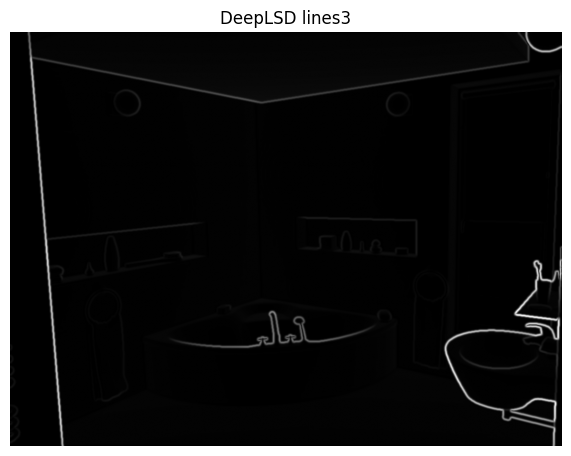

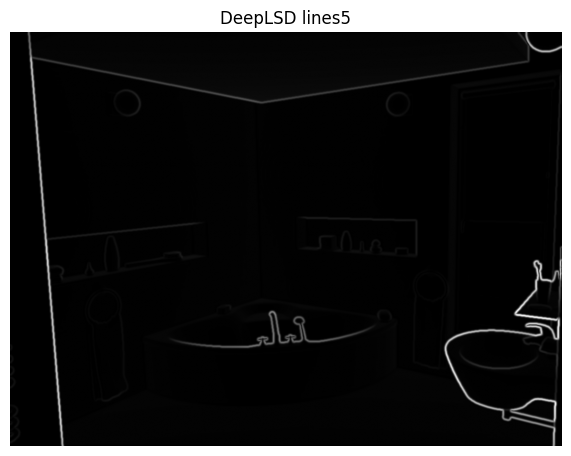

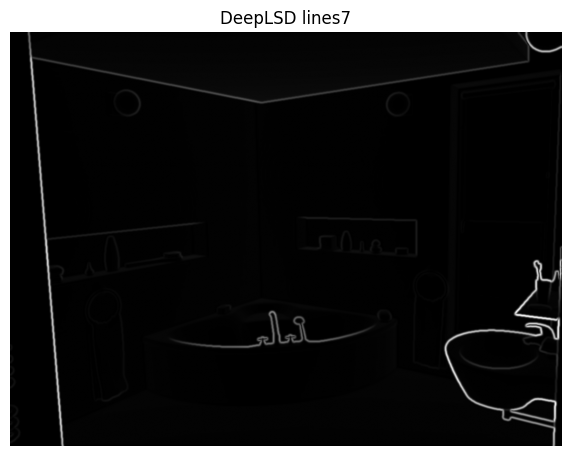

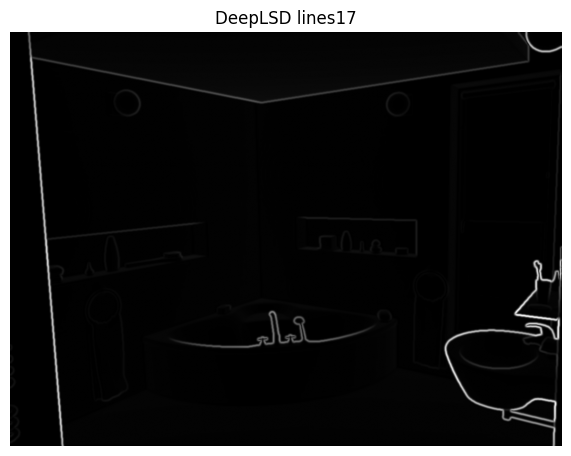

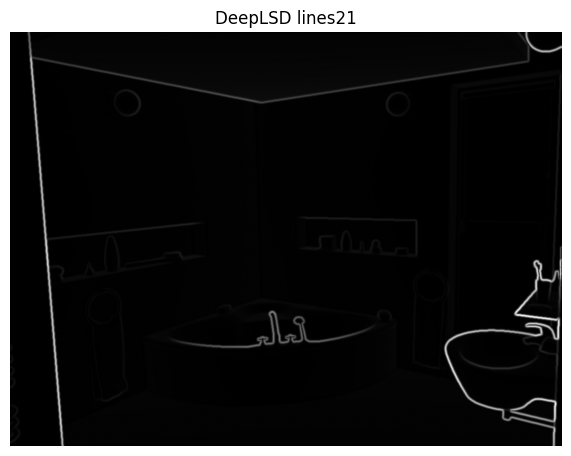

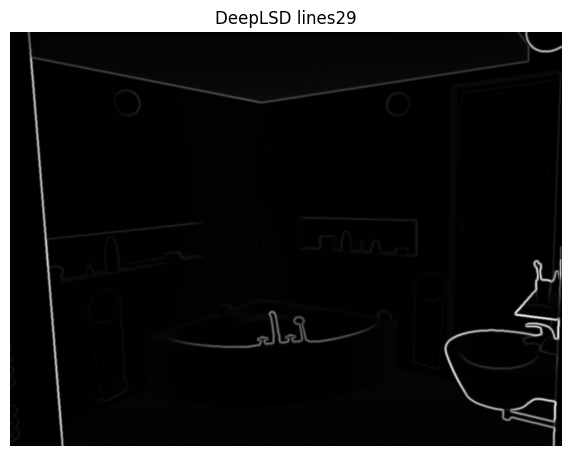

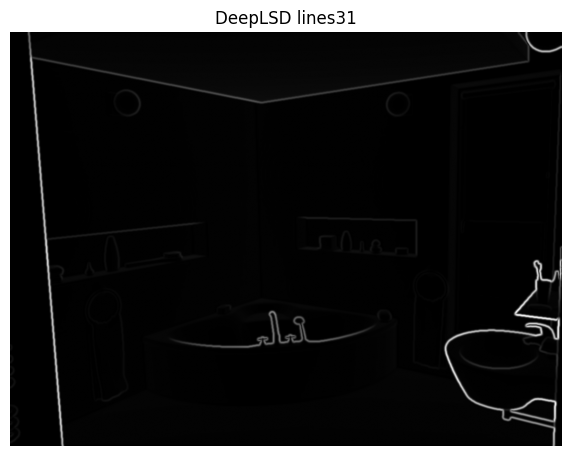

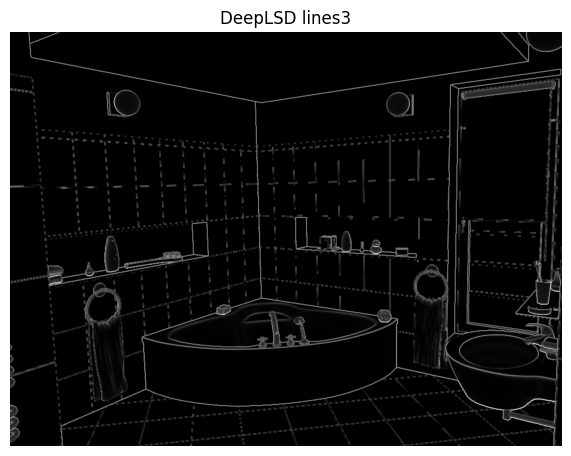

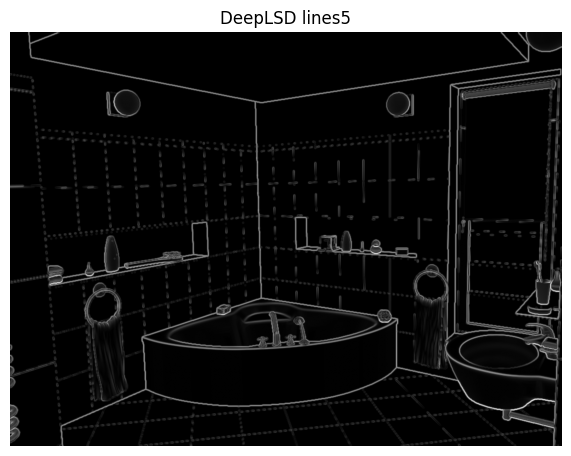

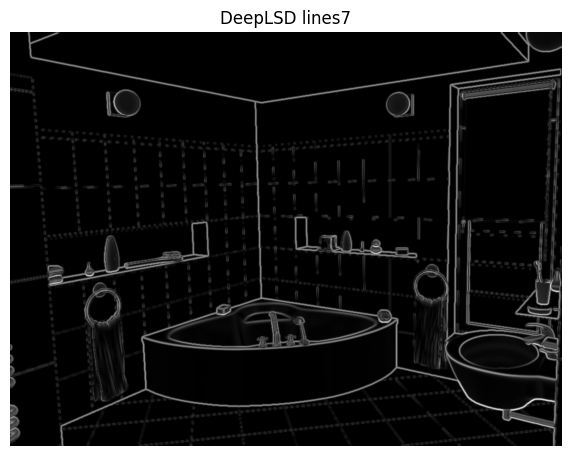

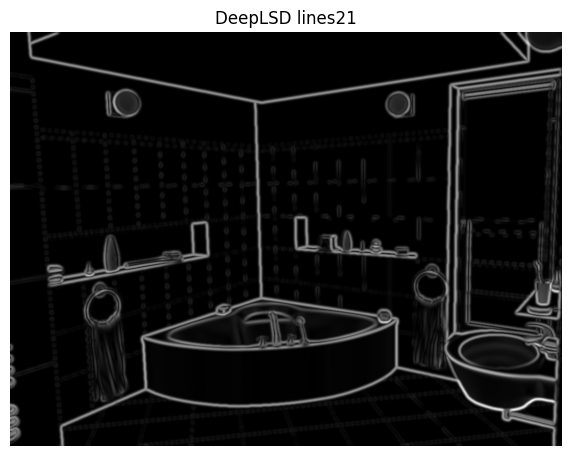

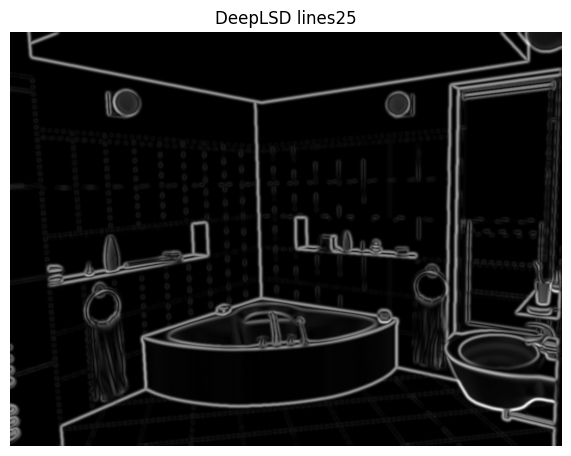

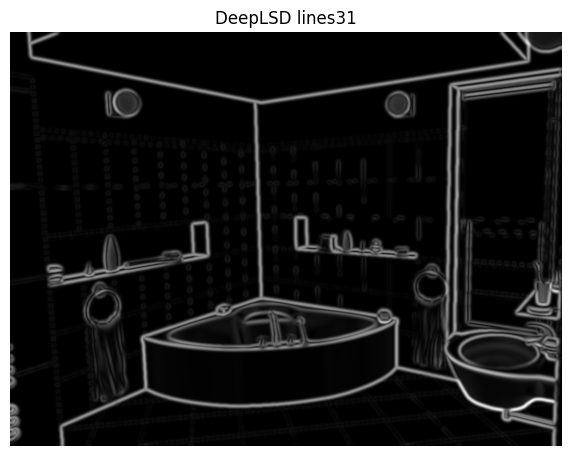

In [10]:


for i in [3,5,7,17,21, 29, 31]:
    sobel_depth = compute_variation(normal_map, i)
    sobel_normal_map = np.max(sobel_depth, axis=2, keepdims=True)
    plot_images([sobel_depth_map], ['DeepLSD lines'+ str(i)], cmaps='gray')

for i in [3,5,7,21,25,31]:
    sobel_normal = compute_variation(normal_map, i)
    sobel_normal_map = np.max(sobel_normal, axis=2, keepdims=True)
    plot_images([sobel_normal_map], ['DeepLSD lines'+ str(i)], cmaps='gray')
